In [61]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', '{:.3f}'.format)
np.set_printoptions(precision=2)

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder, cat_boost

from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn import metrics, model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

import optuna

import torch
from torch import nn, optim

cv_scoring=['f1','accuracy']
target_metrics = [metrics.f1_score, metrics.precision_score]
fromkeys = lambda d, keys: {x:d.get(x) for x in keys}

# Helpfull functions

In [3]:
def type_casting(df_in):
    df = df_in.copy()
    cat_features = ['store_id','region_id','status_id']
    float_feats = ['profit','order_price','max_price','min_price','avg_price','planned_prep_time']
    int_feats = ['delivery_distance','products_count','unique_products_sold_by_store']
    df[cat_features] = df[cat_features].astype('object')
    df[float_feats] = df[float_feats].astype('float')
    df[int_feats] = df[int_feats].astype('int')
    return df

In [4]:
def boxplots_top_stores(df, columns, num_stores=5):
    top_stores = df.value_counts('store_id').sort_values(ascending=False)[:num_stores].index

    _, axes = plt.subplots(nrows=len(columns), 
                        ncols=num_stores+2, figsize=(num_stores*5, len(columns) * 3))
    for idx, feature in enumerate(columns):
        sns.histplot(df[feature], 
                    stat='density', 
                    kde=True,
                    bins=35, ax=axes[idx, 0])
        sns.boxplot(x=feature, data=df, ax=axes[idx, 1]).set_xlabel(feature + ' for all stores')
        for shifted_idx, store_id in enumerate(top_stores, 2):
            sns.boxplot(x=feature, 
                        data=df[df['store_id']==store_id], 
                        ax=axes[idx, shifted_idx]).set_xlabel(feature + ' for ' + str(store_id))
    plt.tight_layout()

In [5]:
def sort_dates(df_in, date_columns):
    df = df_in.copy()
    mask_any_na_dates = df[date_columns].isna().any(axis=1)
    df.loc[~mask_any_na_dates, date_columns] = np.sort(df.loc[~mask_any_na_dates, date_columns].values, axis=1)
    return df

In [6]:
def rm_outliers(df_in, features, quantiles: np.array, verbose=1):
    assert len(features) == len(quantiles)
    df = df_in.copy()
    if verbose:
        print('Shape before removing outliers: ', df.shape)
    IQR = stats.iqr(df[features], axis=0, nan_policy='omit')
    
    mask_non_outliers = df.groupby("store_id")[features]\
        .apply(lambda x : (x>=(np.diag(x.quantile(quantiles[:,0])) - 1.5 * IQR)) 
                        & (x<=(np.diag(x.quantile(quantiles[:,1])) + 1.5 * IQR))\
              ).all(axis=1).values
    df = df[mask_non_outliers]
    if verbose:
        print('Shape after removing outliers: ', df.shape)
    return df

In [7]:
def calc_statistic(frame, method):
    match method:
        case 'mode':
            return frame.mode()
        case 'mean':
            return frame.mean()
        case 'median':
            return frame.median()
        case _:
            raise NameError("Method is not exist") 

In [8]:
def impute_dates_by_store(x_in, method):
    x = x_in.copy()
    # calculate statistics value for recover null observation in regarding the neighbour date feature
    diff_date = x['order_pickup'] - x['order_ready']
    diff_timestamp_statistic = calc_statistic(diff_date[diff_date > pd.to_timedelta("0 days")], method)    

    # From EDA, this column hasn't null rows, but to be sure this code will be left 
    # order_pickup = order_ready + method(order_pickup - order_ready)
    mask_null_order_pickup = x['order_pickup'].isnull() 
    x.loc[mask_null_order_pickup, 'order_pickup'] = \
        x.loc[mask_null_order_pickup, 'order_ready'] + diff_timestamp_statistic
    
    # order_ready = order_pickup - method(order_pickup - order_ready)
    mask_null_order_ready = x['order_ready'].isnull()
    x.loc[mask_null_order_ready, 'order_ready'] = \
        x.loc[mask_null_order_ready, 'order_pickup'] - diff_timestamp_statistic

    # New feature that relfects waiting time for the order to be accepted for processing
    x['order_delay'] = x['order_start_prepare'] - x['date_create']
    diff_timestamp_statistic = calc_statistic(x['order_delay'][x['order_delay'] > pd.to_timedelta("0 days")], method)    
    x['order_delay'] = x['order_delay'].dt.total_seconds() / 60

    # order_start_prepare = date_create + method(order_start_prepare - date_create)
    mask_null_order_start_prepare = x['order_start_prepare'].isnull()
    x.loc[mask_null_order_start_prepare, 'order_start_prepare'] = \
        x.loc[mask_null_order_start_prepare, 'date_create'] + diff_timestamp_statistic
    
    # date_create = order_start_prepare - method(order_start_prepare - date_create)
    mask_null_date_create = x['date_create'].isnull()
    x.loc[mask_null_date_create, 'date_create'] = \
        x.loc[mask_null_date_create, 'order_start_prepare'] - diff_timestamp_statistic

    return x

In [9]:
def impute_dates(df_in, method='mode'):
    df = df_in.copy()
    # Restore dates within a certain store_id by method of differences neighboor columns 
    # (order_pickup - order_ready) & (order_start_prepare - date_create)
    df.loc[:,['date_create','order_start_prepare','order_ready','order_pickup','order_delay']] = df.groupby("store_id")\
            .apply(lambda x: impute_dates_by_store(x, method))\
            .reset_index(allow_duplicates=True)\
            .set_index('level_1')[['date_create','order_start_prepare','order_ready','order_pickup','order_delay']]
    return df

In [10]:
def extract_target(df_in, q_target=0.75, test_subset=False, verbose=1):
    df = df_in.copy()
    df['actual_prep_time'] = (df['order_ready'] - df['order_start_prepare']).dt.total_seconds() / 60
    
    mask_null_prep_time = df['actual_prep_time'].isnull() 
    if not test_subset:
        df['diff_time'] = df['actual_prep_time'] - df['planned_prep_time']
        
        mask_neg_prep_time = df['actual_prep_time'] < 0
        IQR = stats.iqr(df['diff_time'], nan_policy='omit')
        mask_outliers_in_diff_time = df['diff_time'] > (df['diff_time'].quantile(q_target) + 1.5 * IQR)

        if verbose:
            print("Nan's in actual_prep_time: ", mask_null_prep_time.sum(),
                "\nNegatives: ", mask_neg_prep_time.sum(),
                '\nOutliers in time difference: ', mask_outliers_in_diff_time.sum())
        
        df.drop(columns='diff_time', inplace=True)
        df.dropna(subset=['date_create','planned_prep_time'], inplace=True)
        mask_anomaly = mask_neg_prep_time | mask_null_prep_time | mask_outliers_in_diff_time
    else:
        mask_anomaly = mask_null_prep_time
    
    if verbose:
        print("All anomalyes: ", df.loc[mask_anomaly].shape[0])
    df = df.loc[~mask_anomaly]
    df['on_time'] = np.where(abs(df['planned_prep_time'] - df['actual_prep_time']) <= 5, 1, 0)
    return df.drop(columns=['order_ready','order_pickup','actual_prep_time', 'on_time']), df['on_time']


In [11]:
def encode_cyclical_feat(df_in: pd.DataFrame, col: pd.Series, col_name: str):
    df = df_in.copy()
    df[col_name + '_sin'] = np.sin(2 * np.pi * col/col.max())
    df[col_name + '_cos'] = np.cos(2 * np.pi * col/col.max())
    return df

In [12]:
def extract_date_feat(df_in: pd.DataFrame, data_features: list, drop=True, encode_cyclical=True):
    df = df_in.copy()
    if encode_cyclical:
        for col_name in data_features:
            df = encode_cyclical_feat(df, df[col_name].dt.month, col_name + '_month')
            df = encode_cyclical_feat(df, df[col_name].dt.day, col_name + '_day')
            df = encode_cyclical_feat(df, df[col_name].dt.weekday, col_name + '_weekday')
            df = encode_cyclical_feat(df, df[col_name].dt.hour, col_name + '_hour')
            df = encode_cyclical_feat(df, df[col_name].dt.minute, col_name + '_minute')
    else:
        for col_name in data_features:
            df[col_name + '_month'] = df[col_name].dt.month
            df[col_name + '_day'] = df[col_name].dt.day
            df[col_name + '_weekday'] = df[col_name].dt.weekday
            df[col_name + '_hour'] = df[col_name].dt.hour
            df[col_name + '_minute'] = df[col_name].dt.minute
            
    if drop:
        df = df.drop(columns=data_features)
    return df

In [13]:
def simple_imputer(X_train, X_test, y_train, y_test, restore_numerical_nans=True, 
                   imputing_method_for_numerical='mode', 
                   imputing_method_for_simple_imputer='most_frequent', verbose=1):
    na_columns_train = X_train.columns[X_train.isna().any()]
    na_columns_test = X_test.columns[X_test.isna().any()]

    if verbose: 
        print("Numbers of NaN values\n\tTrain:\n", X_train[na_columns_train].isna().sum())
        print("\n\tTest:\n", X_test[na_columns_test].isna().sum())

    if restore_numerical_nans:
        X_train.loc[:,na_columns_train] = X_train.groupby("store_id")\
            [na_columns_train].transform(lambda x: x.fillna(calc_statistic(x, imputing_method_for_numerical)))
        X_test.loc[:,na_columns_test] = X_test.groupby("store_id")\
            [na_columns_test].transform(lambda x: x.fillna(calc_statistic(x, imputing_method_for_numerical)))

        ####################################### Imputting #####################################
        col_imputing = X_test.columns[X_test.isna().any()].union(X_train.columns[X_train.isna().any()])
        if verbose:
            print("Remaining numbers of NaN values\n\tTrain:\n", X_train[col_imputing].isna().sum())
            print("\n\tTest:\n", X_test[col_imputing].isna().sum())

        imputer = SimpleImputer(strategy=imputing_method_for_simple_imputer)
        X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), 
                                            columns=col_imputing, index=X_train.index)
        X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), 
                                            columns=col_imputing, index=X_test.index)
    else:
        index_train_na, index_test_na = X_train[na_columns_train].isnull().any(axis=1), \
                                        X_test[na_columns_test].isnull().any(axis=1)    
        X_train, y_train, X_test, y_test = X_train[~index_train_na], y_train[~index_train_na], \
                                        X_test[~index_test_na], y_test[~index_test_na]
    return X_train, X_test, y_train, y_test

In [14]:
def scores(estimator, X_test, y_test, X_train, y_train, cv=5, cv_scoring=cv_scoring, threshold=0.5, plot=True, ax=None):
    precision = 3
    if threshold:
        pred_proba = estimator.predict_proba(X_test)
        y_test_pred = np.where(pred_proba[:, 1] > threshold, 1, 0)
    else:
        y_test_pred = estimator.predict(X_test)

    # calculate metrics
    print(f'- Testing accuracy = {metrics.accuracy_score(y_test, y_test_pred):.{precision}f}',
          f'\n- Testing precision = {metrics.precision_score(y_test, y_test_pred):.{precision}f}',
          f'\n- Testing recall = {metrics.recall_score(y_test, y_test_pred):.{precision}f}',
          f'\n- Testing f1_score = {metrics.f1_score(y_test, y_test_pred):.{precision}f}',
          f'\n- Testing ROC AUC = {metrics.roc_auc_score(y_test, y_test_pred):.{precision}f}')
    if cv:
        print('- Cross validate: ', model_selection.cross_validate(estimator, 
                                                                  pd.concat([X_train, X_test]), 
                                                                  pd.concat([y_train, y_test]), 
                                                                  cv=cv, scoring=cv_scoring))
  
    if plot: 
        cm = confusion_matrix(y_test, y_test_pred, labels=estimator.classes_, 
                        #   normalize='true'
                        )
        ConfusionMatrixDisplay(cm, display_labels=estimator.classes_).plot(ax=ax)
        return cm
    

# EDA

In [42]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=date_columns)

orders = type_casting(orders)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       517610 non-null  object        
 1   profit                         466225 non-null  float64       
 2   delivery_distance              517610 non-null  int64         
 3   date_create                    517337 non-null  datetime64[ns]
 4   order_start_prepare            465814 non-null  datetime64[ns]
 5   planned_prep_time              517609 non-null  float64       
 6   order_ready                    466244 non-null  datetime64[ns]
 7   order_pickup                   517610 non-null  datetime64[ns]
 8   region_id                      517610 non-null  object        
 9   status_id                      517610 non-null  object        
 10  products_count                 517610 non-null  int64         
 11  

In [43]:
X, y = extract_target(orders, 1.0)
date_columns = ['date_create', 'order_start_prepare']
df = pd.concat([X,y], axis=1)
df.shape

Nan's in actual_prep_time:  97930 
Negatives:  1855 
Outliers in time difference:  0
All anomalyes:  99716


(417620, 15)

([<matplotlib.patches.Wedge at 0x7f9d282a9030>,
 [Text(-0.14313714705728628, 1.0906474027532, 'Late'),
  Text(0.14313714705728586, -1.0906474027532, 'On time')],
 [Text(-0.0780748074857925, 0.5948985833199272, '54.2%'),
  Text(0.07807480748579228, -0.5948985833199273, '45.8%')])

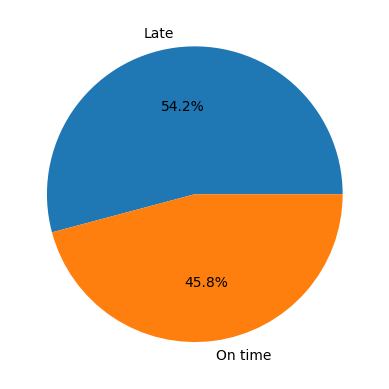

In [44]:
plt.pie(x=y.value_counts().values,
        labels=y.value_counts().index.map({0:'Late', 1:"On time"}), 
        autopct='%0.01f%%')

In [45]:
top_stores = df['store_id'].value_counts().index[:12]
print('Top stores: ', top_stores)
df_top_stores = df[df['store_id'].isin(top_stores)]
df_top_stores.shape

Top stores:  Index([3503, 5212, 5014, 4742, 3902, 3141, 4755, 3053, 6579, 3496, 3766,
       10489],
      dtype='object', name='store_id')


(52308, 15)

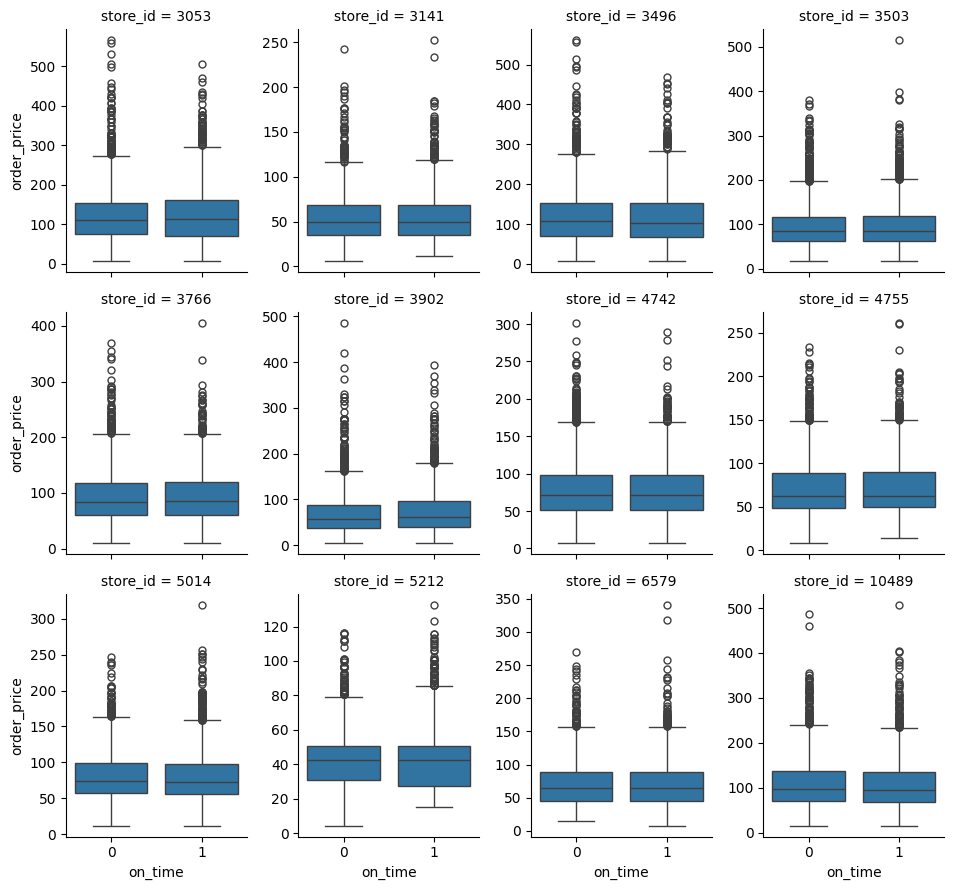

In [46]:
sns.catplot(
    x="on_time",
    y="order_price",
    col="store_id",
    data=df_top_stores,
    kind="box",
    col_wrap=4,
    height=3,
    aspect=0.8, sharey=False
)

In [47]:
df_extracted_dates = extract_date_feat(df_top_stores, date_columns, encode_cyclical=False)
df_extracted_dates.columns

Index(['store_id', 'profit', 'delivery_distance', 'planned_prep_time',
       'region_id', 'status_id', 'products_count', 'order_price', 'max_price',
       'min_price', 'avg_price', 'unique_products_sold_by_store', 'on_time',
       'date_create_month', 'date_create_day', 'date_create_weekday',
       'date_create_hour', 'date_create_minute', 'order_start_prepare_month',
       'order_start_prepare_day', 'order_start_prepare_weekday',
       'order_start_prepare_hour', 'order_start_prepare_minute'],
      dtype='object')

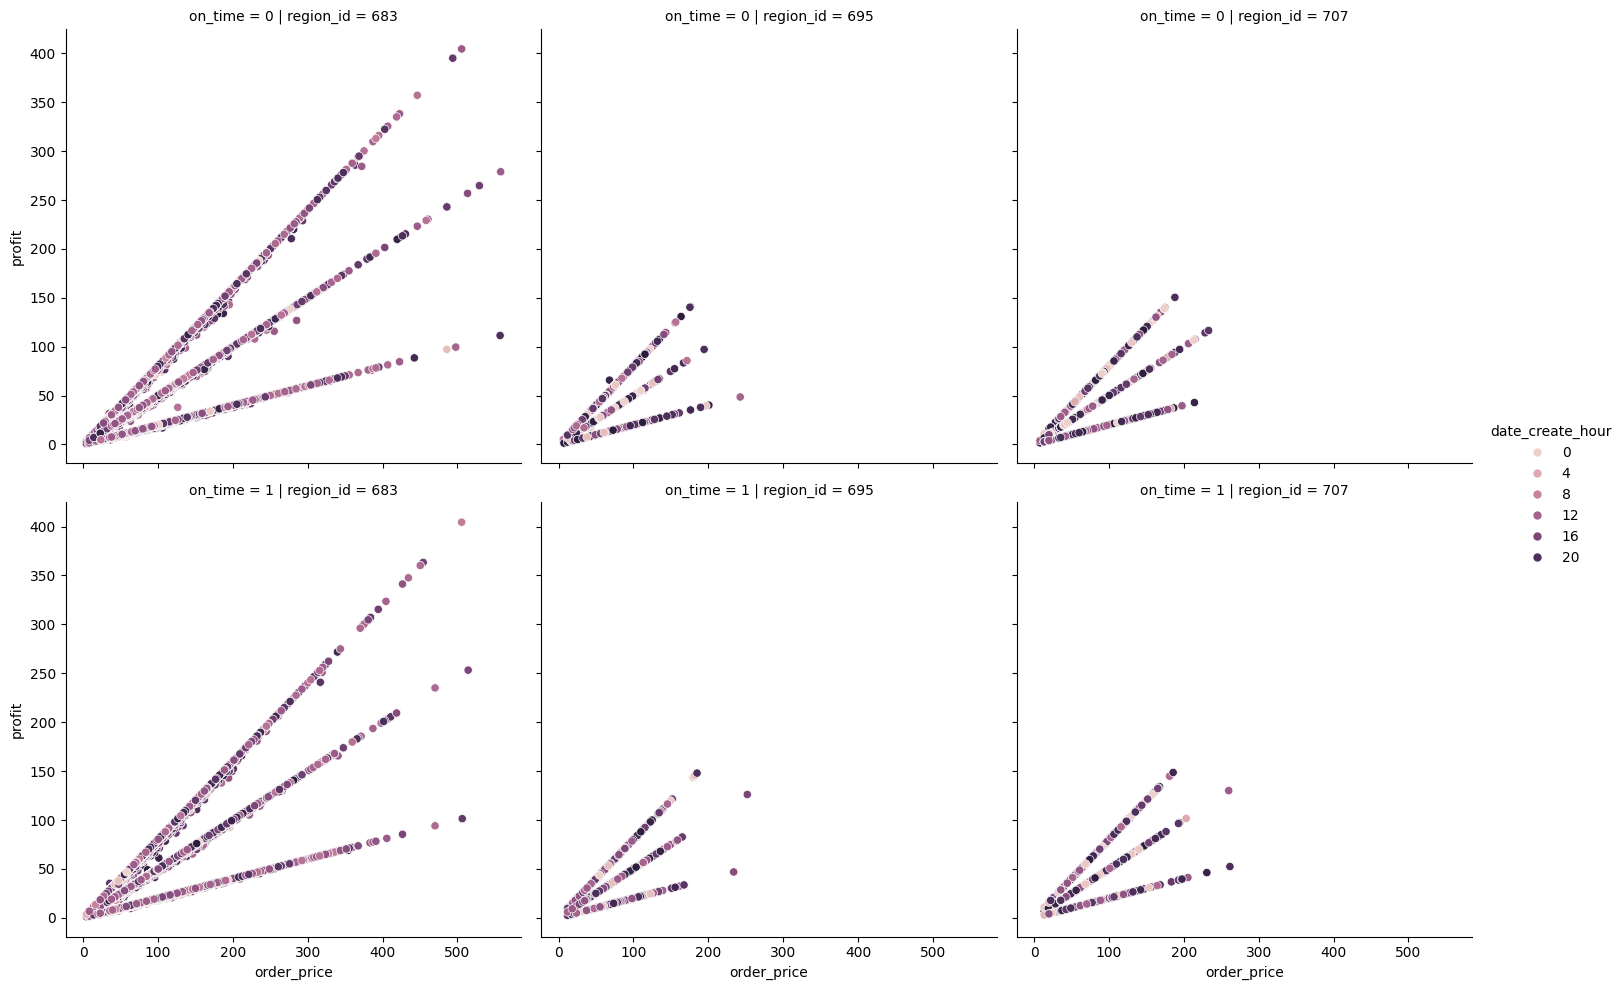

In [48]:
sns.relplot(df_extracted_dates, 
            kind="scatter",
            x='order_price', y='profit', 
            hue='date_create_hour', #hue_order=(15, 90),
            col="region_id", row='on_time')

The same, but without outliers

Shape before removing outliers:  (417620, 23)
Shape after removing outliers:  (368308, 23)


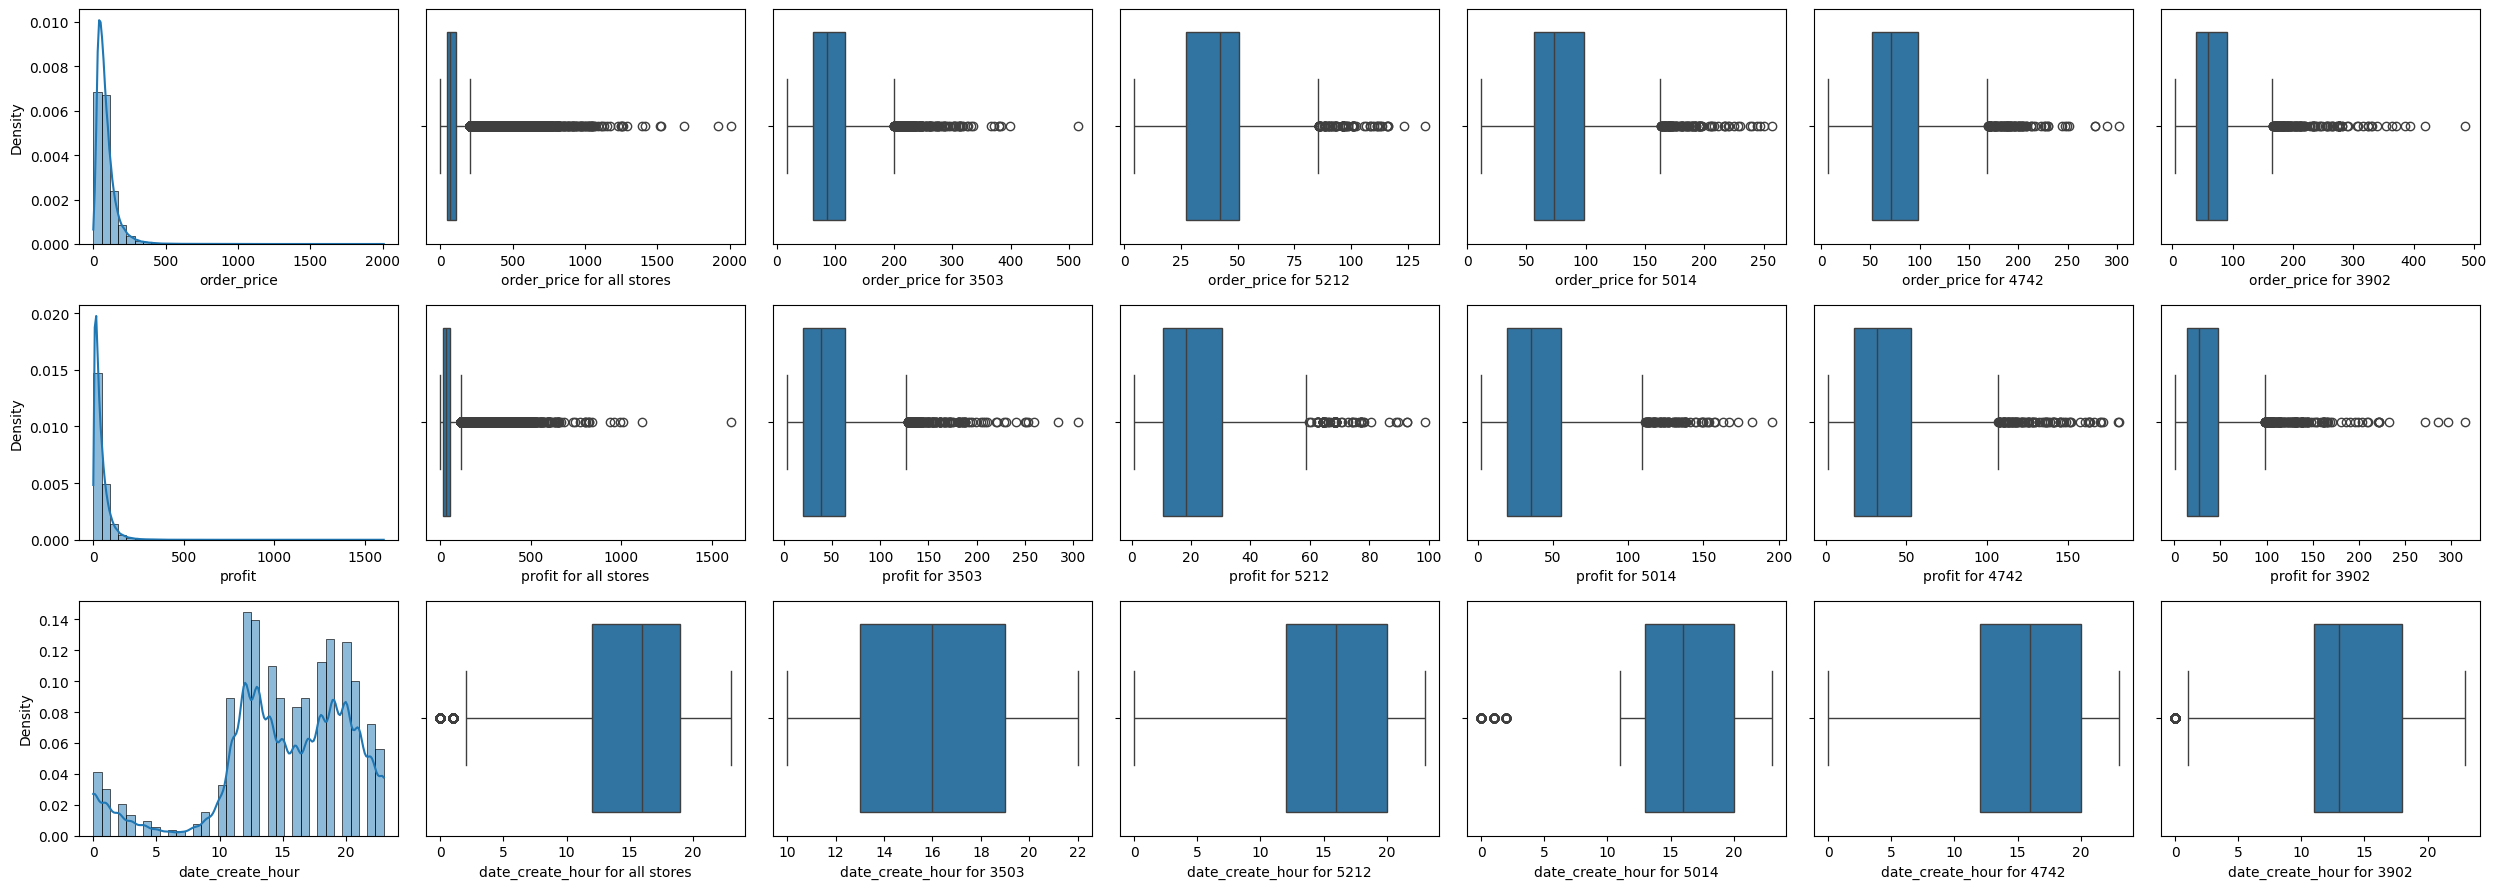

In [49]:
df_without_outliers = rm_outliers(extract_date_feat(df, date_columns, encode_cyclical=False), 
                                  ['order_price', 'profit'], np.array([[0.0, 0.9]]*2))
boxplots_top_stores(df_without_outliers, ['order_price', 'profit', 'date_create_hour'])

In [50]:
top_stores = df_without_outliers['store_id'].value_counts().index[:12]
print('Top stores: ', top_stores)
df_top_stores = df_without_outliers[df_without_outliers['store_id'].isin(top_stores)]
df_top_stores.shape

Top stores:  Index([3503, 5212, 5014, 4742, 3902, 3141, 4755, 3053, 6579, 3496, 3766,
       10489],
      dtype='object', name='store_id')


(46122, 23)

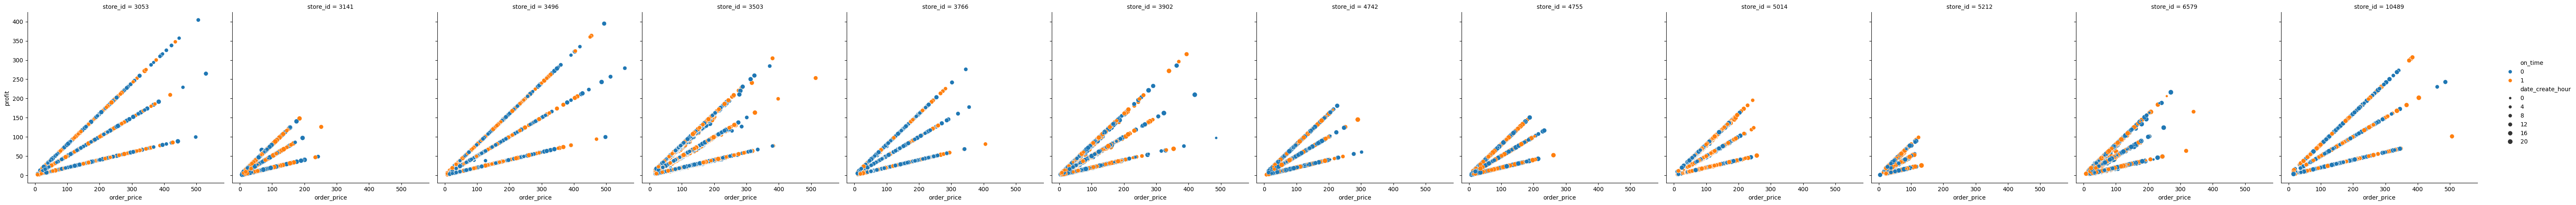

In [51]:
sns.relplot(df_top_stores, 
            kind="scatter",
            x='order_price', y='profit', 
            hue='on_time', #hue_order=(15, 90),
            size='date_create_hour',
            col="store_id", 
            # row='region_id'
            )

In [65]:
number_columns = df.select_dtypes('number').columns
number_columns

Index(['profit', 'delivery_distance', 'planned_prep_time', 'products_count',
       'order_price', 'max_price', 'min_price', 'avg_price',
       'unique_products_sold_by_store', 'on_time'],
      dtype='object')

In [87]:
df.groupby('status_id')[number_columns].describe()['planned_prep_time']

,count,mean,std,min,25%,50%,75%,max
status_id,,,,,,,,
C,58.00000,23.48276,13.18591,5.00000,15.00000,20.00000,30.00000,85.00000
F,417562.00000,23.28454,8.26111,0.00000,20.00000,20.00000,30.00000,180.00000


# Models

## Logistic Regression

### Preprocessing

In [15]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=date_columns)

orders = type_casting(orders)
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517610 entries, 0 to 517609
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   store_id                       517610 non-null  object        
 1   profit                         466225 non-null  float64       
 2   delivery_distance              517610 non-null  int64         
 3   date_create                    517337 non-null  datetime64[ns]
 4   order_start_prepare            465814 non-null  datetime64[ns]
 5   planned_prep_time              517609 non-null  float64       
 6   order_ready                    466244 non-null  datetime64[ns]
 7   order_pickup                   517610 non-null  datetime64[ns]
 8   region_id                      517610 non-null  object        
 9   status_id                      517610 non-null  object        
 10  products_count                 517610 non-null  int64         
 11  

In [16]:
orders = sort_dates(orders, date_columns)

In [17]:
features_for_rm_outls = orders.select_dtypes('number').columns
# boxplots_top_stores(orders, features_for_rm_outls)

In [18]:
quantiles = np.array([[0.25, 0.75]]*len(features_for_rm_outls))
rmvd_outliers = rm_outliers(orders, features_for_rm_outls, quantiles)
# boxplots_top_stores(rmvd_outliers, features_for_rm_outls)

Shape before removing outliers:  (517610, 16)


Shape after removing outliers:  (412084, 16)


In [19]:
rmvd_outliers['status_id'].value_counts(dropna=False)

status_id
F    412008
C        76
Name: count, dtype: int64

<Axes: >

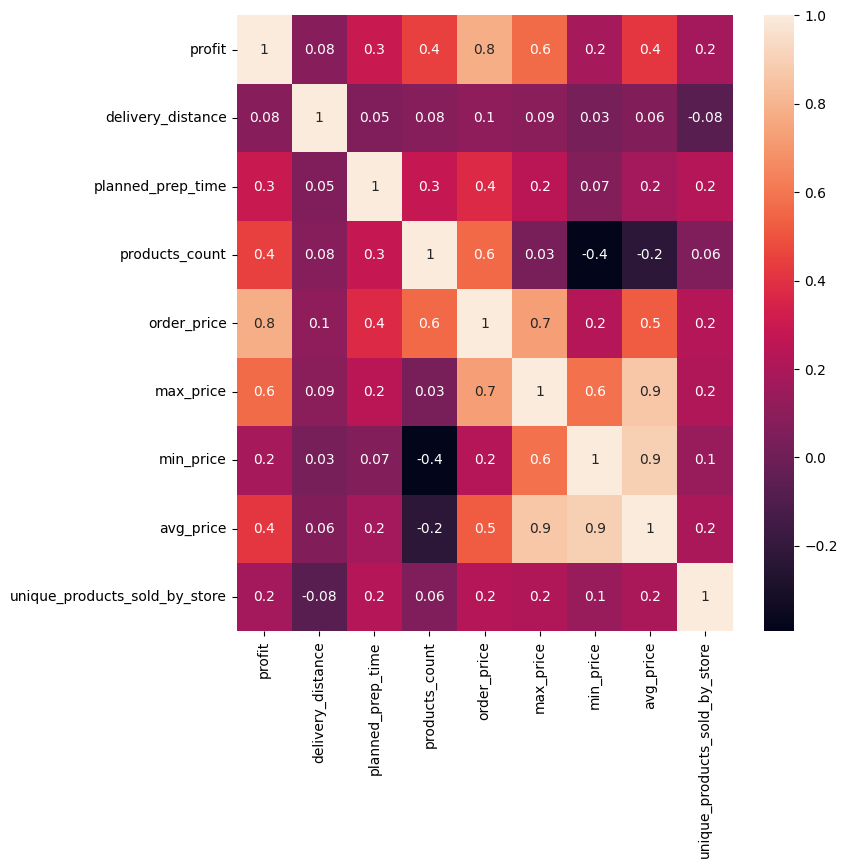

In [20]:
plt.subplots(figsize=(8,8))
corr_matrix = rmvd_outliers.select_dtypes('number').corr()
sns.heatmap(corr_matrix, annot=True, fmt='.1g')

In [21]:
rmvd_outliers = rmvd_outliers.drop(columns=['status_id','avg_price'])

In [22]:
X_train, X_test = train_test_split(rmvd_outliers, train_size=0.9, shuffle=True)

In [23]:
X_train = impute_dates(X_train, 'mean')
X_test = impute_dates(X_test, 'mean')

In [24]:
X_train, y_train = extract_target(X_train, q_target=0.75)
X_test, y_test = extract_target(X_test, test_subset=True)
data_features = ['date_create','order_start_prepare']

Nan's in actual_prep_time:  25 
Negatives:  483 
Outliers in time difference:  12585
All anomalyes:  13075
All anomalyes:  24


<Axes: >

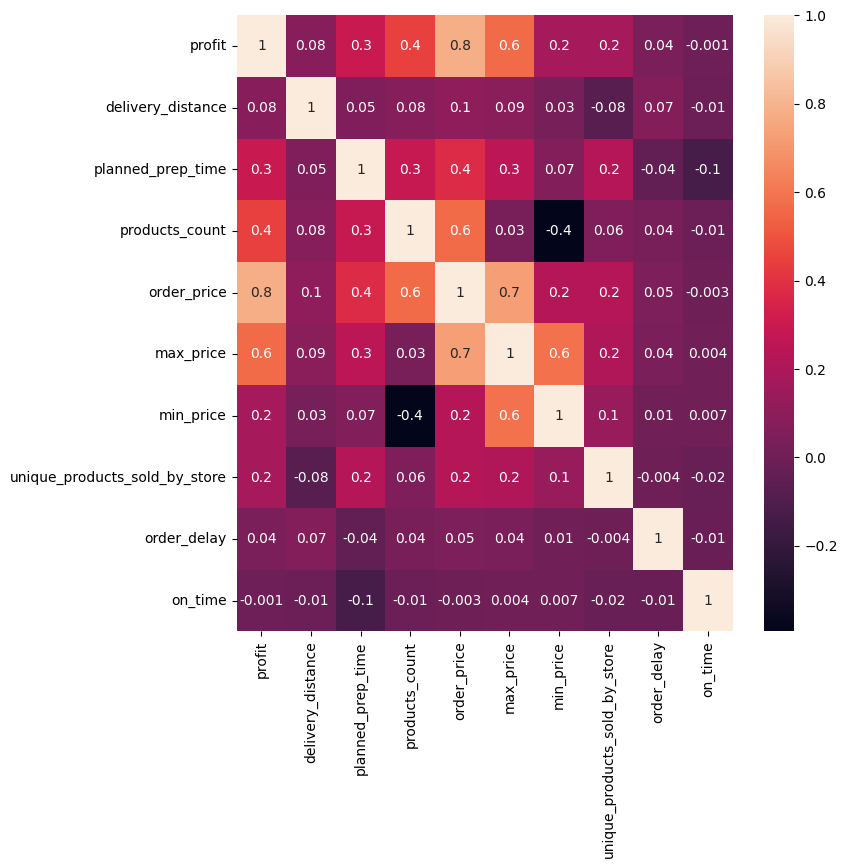

In [25]:
plt.subplots(figsize=(8,8))
corr_matrix = pd.concat([X_train.select_dtypes('number'), y_train], axis=1).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.1g')

There is some correlation with planned_prep_time

([<matplotlib.patches.Wedge at 0x7f2ebb9de110>,
 [Text(-0.11722366036120668, 1.0937360803464062, 'Late'),
  Text(0.11722355795824356, -1.0937360913216727, 'On time')],
 [Text(-0.06394017837884, 0.5965833165525852, '53.4%'),
  Text(0.06394012252267829, -0.5965833225390942, '46.6%')])

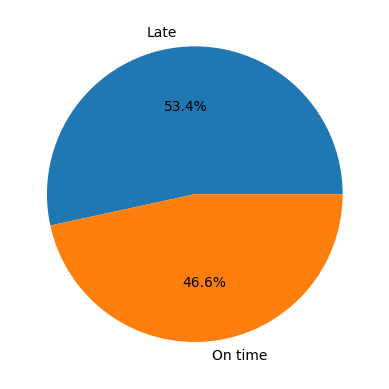

In [26]:
plt.pie(x=y_train.value_counts().values,
        labels=y_train.value_counts().index.map({0:'Late', 1:"On time"}), 
        autopct='%0.01f%%')

The classes are almost balanced

In [27]:
X_train = extract_date_feat(X_train, data_features)
X_test = extract_date_feat(X_test, data_features)
X_train.columns

Index(['store_id', 'profit', 'delivery_distance', 'planned_prep_time',
       'region_id', 'products_count', 'order_price', 'max_price', 'min_price',
       'unique_products_sold_by_store', 'order_delay', 'date_create_month_sin',
       'date_create_month_cos', 'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos'],
      dtype='object')

In [28]:
X_train, X_test, y_train, y_test = simple_imputer(X_train, X_test, y_train, y_test, 
                                                  imputing_method_for_numerical='mean', imputing_method_for_simple_imputer='mean')

Numbers of NaN values
	Train:
 profit         35508
max_price        135
min_price        135
order_delay    35047
dtype: int64

	Test:
 profit         4043
max_price        19
min_price        19
order_delay    4099
dtype: int64
Remaining numbers of NaN values
	Train:
 max_price    0
min_price    0
profit       5
dtype: int64

	Test:
 max_price     1
min_price     1
profit       10
dtype: int64


In [29]:
###################################### Encoding #####################################
cat_features = ['store_id','region_id']
encoder = cat_boost.CatBoostEncoder(cols=cat_features)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

In [30]:
##################################### Scaling #####################################
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out(), index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out(), index=X_test.index)

In [31]:
X_train.shape, X_test.shape

((357781, 31), (41185, 31))

### Training

In [32]:
def get_best_threshold(model, X_test, y_test, objective_targets, plot=False):
    thresholds = np.arange(0.1, 0.9, 0.01)
    pred_proba = model.predict_proba(X_test)

    averaged_results = []
    results = [[] for i in range(len(objective_targets)) ]
    for i in thresholds:
        y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
        [
            results[idx].append(metric_func(y_test, y_test_pred_thr)) 
            for idx, metric_func 
            in enumerate(objective_targets)
        ]
        averaged_results.append(np.min([result[-1] for result in results]))
    
    if plot:
        [plt.plot(thresholds, results[idx], label=metric) 
        for idx, metric in enumerate(objective_targets)]
        plt.title('Threshold Selection')
        plt.xlabel('threshold')
        plt.ylabel('score')
        plt.legend()
        plt.grid()

    return np.max(averaged_results), thresholds[np.argmax(averaged_results)]

In [33]:
def logistic_regressor(X_train, y_train, X_test, y_test, objective_targets=target_metrics, plot=False):
    clf = LogisticRegression(random_state=42, n_jobs=-1).fit(X_train, y_train)
    return clf, get_best_threshold(clf, X_test, y_test, objective_targets, plot)

In [34]:
def logistic_regressor_scores(clf, X_test, y_test, X_train, y_train, cv=5, cv_scoring=cv_scoring, best_threshold=0.5, plot=False):
    print("----Logistic Regression Coefficients----")
    importance_features = {col: abs(w)  for col, w in zip(list(X_train.columns), clf.coef_[0])}
    importance_features = dict(sorted(importance_features.items(), key=lambda x:x[1], reverse=True))

    _, axes = plt.subplots(1,2, figsize=(12,5))
    sns.barplot(importance_features, 
                orient='h',
                ax=axes[0]).set_title('Feature weight in Logistic regression')

    scores(clf, X_test, y_test, X_train, y_train, cv, cv_scoring, threshold=best_threshold, ax=axes[1], plot=plot)
    plt.tight_layout()
    plt.show()

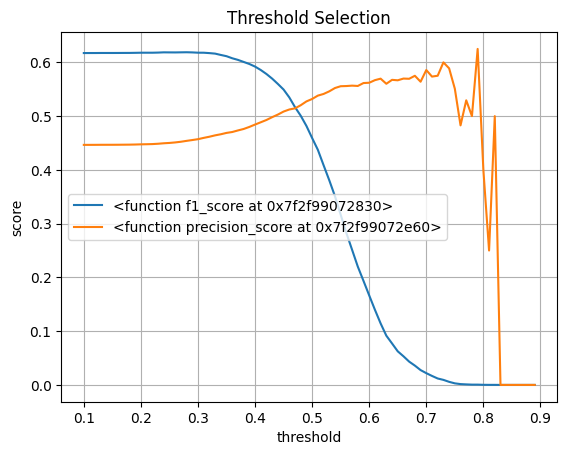

In [35]:
clf, min_of_all_scores__best_threshold = logistic_regressor(X_train, y_train, X_test, y_test, objective_targets=target_metrics, plot=True)
min_of_all_scores, best_threshold = min_of_all_scores__best_threshold

----Logistic Regression Coefficients----
- Testing accuracy = 0.567 
- Testing precision = 0.514 
- Testing recall = 0.519 
- Testing f1_score = 0.517 
- Testing ROC AUC = 0.562


- Cross validate:  {'fit_time': array([2.27, 3.56, 2.2 , 2.54, 2.43]), 'score_time': array([0.09, 0.03, 0.07, 0.03, 0.06]), 'test_f1': array([0.49, 0.5 , 0.49, 0.5 , 0.47]), 'test_accuracy': array([0.58, 0.59, 0.58, 0.59, 0.58])}


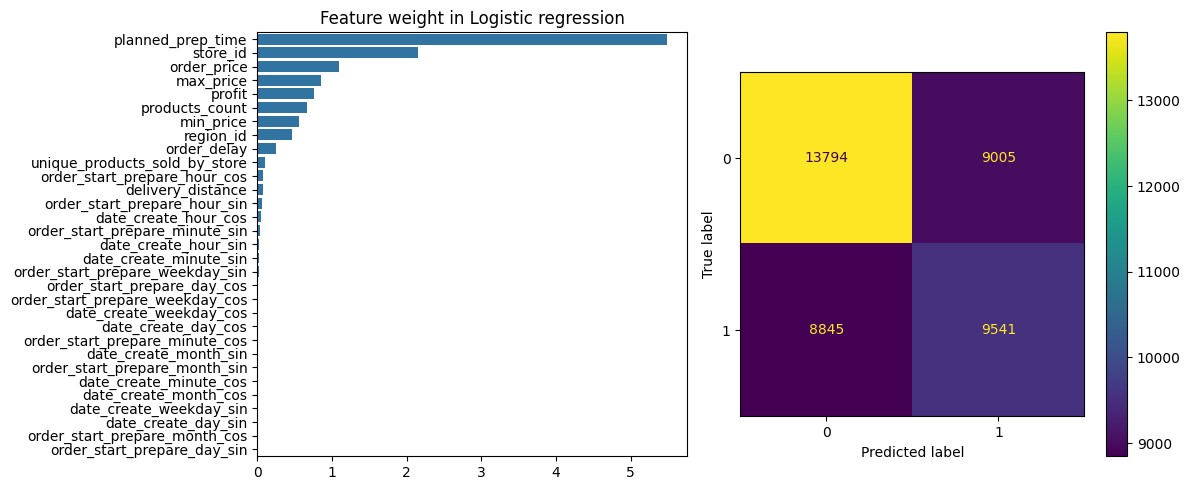

In [36]:
logistic_regressor_scores(clf, X_test, y_test, X_train, y_train, cv=5, cv_scoring=cv_scoring, best_threshold=best_threshold, plot=True)

### Balancing dataset

([<matplotlib.patches.Wedge at 0x7f2ebb5bea10>,
 [Text(-0.11722366036120668, 1.0937360803464062, 'Late'),
  Text(0.11722355795824356, -1.0937360913216727, 'On time')],
 [Text(-0.06394017837884, 0.5965833165525852, '53.4%'),
  Text(0.06394012252267829, -0.5965833225390942, '46.6%')])

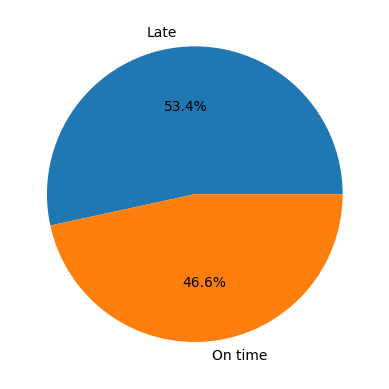

In [37]:
plt.pie(x=y_train.value_counts().values,
        labels=y_train.value_counts().index.map({0:'Late', 1:"On time"}), 
        autopct='%0.01f%%')

In [38]:
X_smote, y_smote = SMOTE(random_state=42, k_neighbors=500).fit_resample(X_train, y_train)

print(X_train.shape, y_train.value_counts())
print(X_smote.shape, y_smote.value_counts())

(357781, 31) on_time
0    191050
1    166731
Name: count, dtype: int64
(382100, 31) on_time
0    191050
1    191050
Name: count, dtype: int64


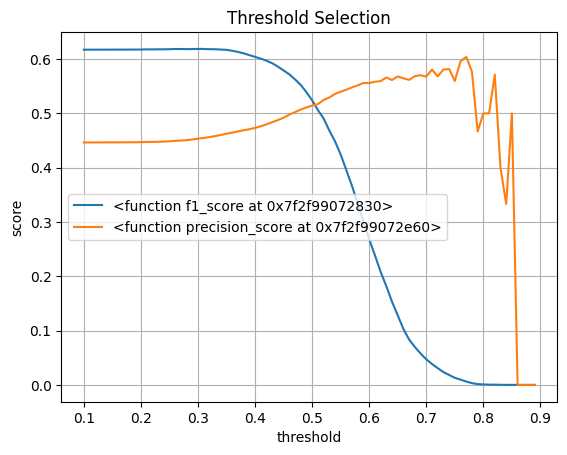

In [39]:
clf_smote, min_of_all_scores__best_threshold = logistic_regressor(X_smote, y_smote, X_test, y_test, objective_targets=target_metrics, plot=True)
min_of_all_scores, best_threshold_smote = min_of_all_scores__best_threshold

----Logistic Regression Coefficients----
- Testing accuracy = 0.567 
- Testing precision = 0.514 
- Testing recall = 0.534 
- Testing f1_score = 0.524 
- Testing ROC AUC = 0.564


- Cross validate:  {'fit_time': array([1.98, 3.99, 2.32, 2.55, 2.43]), 'score_time': array([0.05, 0.04, 0.04, 0.08, 0.04]), 'test_f1': array([0.56, 0.57, 0.57, 0.57, 0.56]), 'test_accuracy': array([0.57, 0.58, 0.58, 0.58, 0.57])}


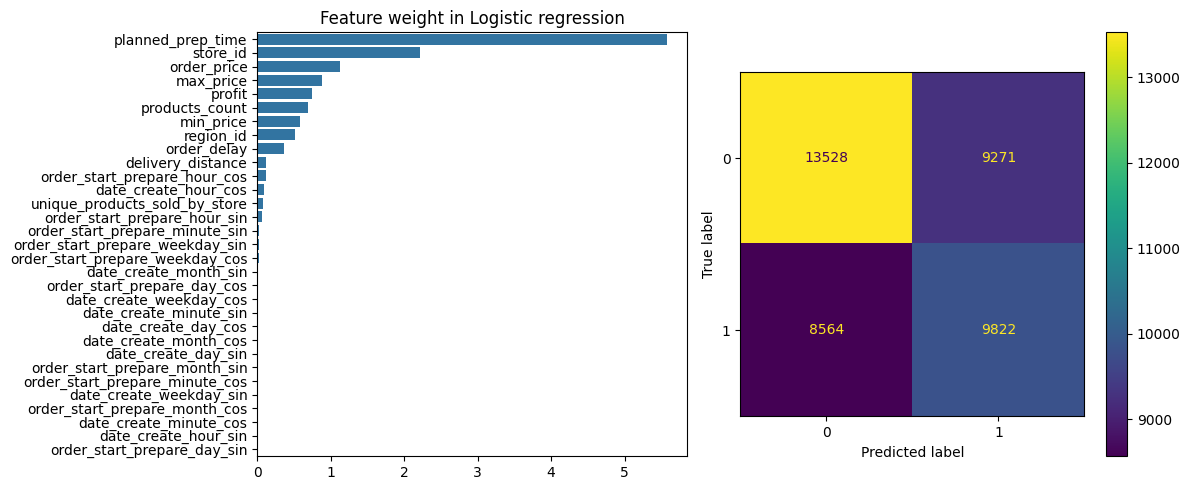

In [40]:
logistic_regressor_scores(clf_smote, X_test, y_test, X_smote, y_smote, cv=5, cv_scoring=cv_scoring, best_threshold=best_threshold_smote, plot=True)

after balancing, the model performs better on the f1_score cross validation

In [41]:
X_borderline_smote, y_borderline_smote = BorderlineSMOTE(random_state=42, k_neighbors=500)\
    .fit_resample(X_train, y_train)

print(X_train.shape, y_train.value_counts())
print(X_borderline_smote.shape, y_borderline_smote.value_counts())

(357781, 31) on_time
0    191050
1    166731
Name: count, dtype: int64
(382100, 31) on_time
0    191050
1    191050
Name: count, dtype: int64


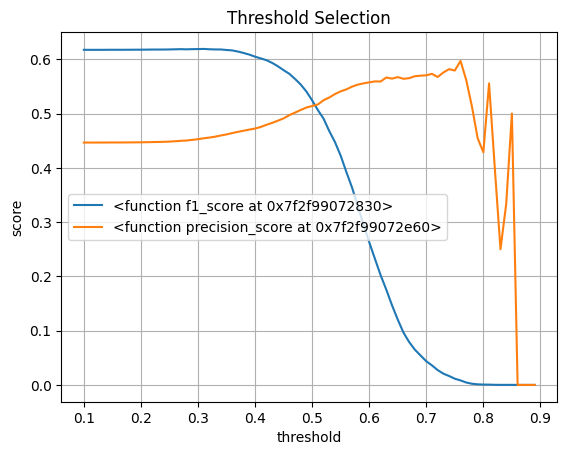

In [42]:
clf_bln_smote, min_of_all_scores__best_threshold = logistic_regressor(X_borderline_smote, y_borderline_smote, X_test, y_test, objective_targets=target_metrics, plot=True)
min_of_all_scores, best_threshold_borderline_smote = min_of_all_scores__best_threshold

----Logistic Regression Coefficients----
- Testing accuracy = 0.566 
- Testing precision = 0.514 
- Testing recall = 0.535 
- Testing f1_score = 0.524 
- Testing ROC AUC = 0.563


- Cross validate:  {'fit_time': array([2.8 , 2.09, 2.74, 2.29, 2.26]), 'score_time': array([0.04, 0.04, 0.04, 0.08, 0.04]), 'test_f1': array([0.56, 0.57, 0.57, 0.57, 0.55]), 'test_accuracy': array([0.57, 0.58, 0.58, 0.58, 0.57])}


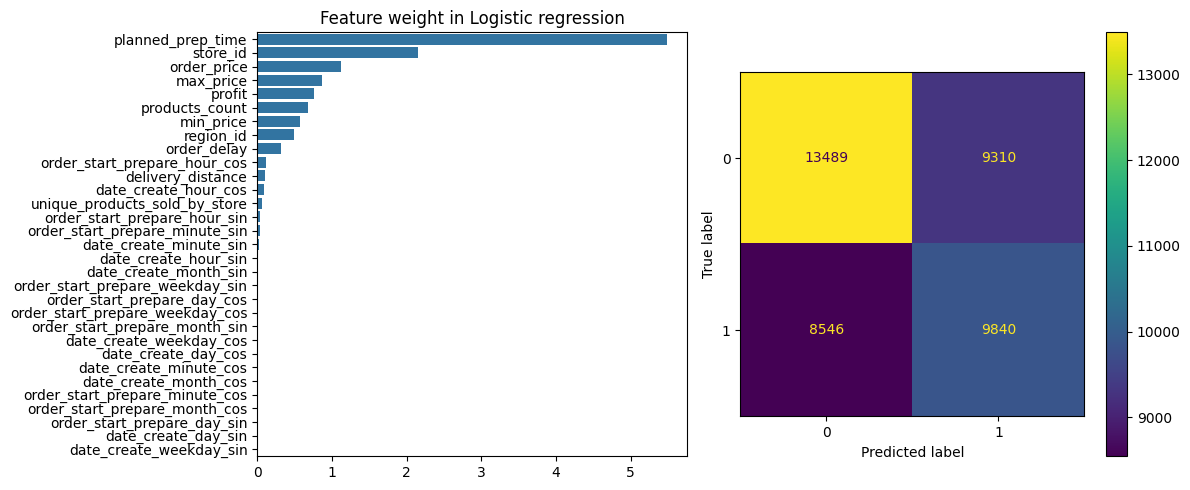

In [43]:
logistic_regressor_scores(clf_bln_smote, X_test, y_test, X_borderline_smote, y_borderline_smote, cv=5, cv_scoring=cv_scoring, best_threshold=best_threshold_borderline_smote, plot=True)

almost the same thing, although the f1_score has increased slightly in the test

### SVC

In [59]:
X_sample = X_borderline_smote.sample(10000)
y_sample = y_borderline_smote.loc[X_sample.index]

svc = SVC(kernel='rbf', verbose=1).fit(X_sample, y_sample)

[LibSVM]......*.*
optimization finished, #iter = 7062
obj = -8784.326307, rho = -3.042982
nSV = 9241, nBSV = 8998
Total nSV = 9241


- Testing accuracy = 0.553 
- Testing precision = 0.499 
- Testing recall = 0.513 
- Testing f1_score = 0.506 
- Testing ROC AUC = 0.549

               precision    recall  f1-score   support

           0       0.59      0.60      0.59     22290
           1       0.51      0.50      0.51     18895

    accuracy                           0.55     41185
   macro avg       0.55      0.55      0.55     41185
weighted avg       0.55      0.55      0.55     41185



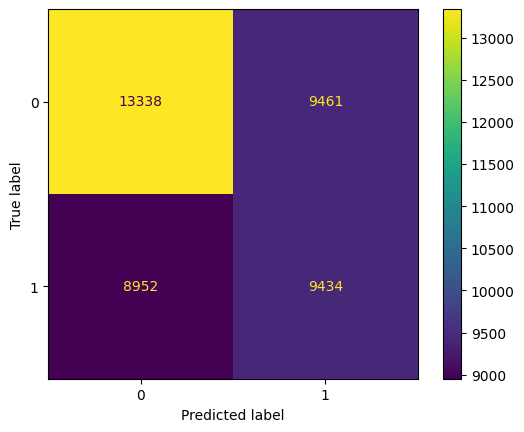

In [60]:
scores(svc, X_test, y_test, X_sample, y_sample, cv=None, threshold=None)
y_pred = svc.predict(X_test)
print("\n", metrics.classification_report(y_pred, y_test))

### Neural Network (MLP)

In [119]:
X_train_tr.shape

torch.Size([382100, 31])

In [145]:
X_train_tr, X_test_tr, y_train_tr, y_test_tr = (torch.tensor(batch.values, dtype=torch.float32, device='cuda') 
                                                                for batch 
                                                                in (X_borderline_smote, X_test, y_borderline_smote, y_test))

type(X_train_tr), X_train_tr.shape, type(y_train_tr), y_train_tr.shape

(torch.Tensor, torch.Size([382100, 31]), torch.Tensor, torch.Size([382100]))

In [127]:
# Архитектура модели
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(31, 108)  # Входной размер - 31
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.1007)

        self.fc2 = nn.Linear(108, 213)
        self.bn2 = nn.BatchNorm1d(213)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.118)

        self.fc3 = nn.Linear(213, 1)  # Последний слой выдает 1 значение
        self.sigmoid = nn.Sigmoid()  # Для бинарной классификации

    def forward(self, x):
        x = self.dropout1(self.elu1(self.fc1(x)))
        x = self.dropout2(self.elu2(self.bn2(self.fc2(x))))
        x = self.sigmoid(self.fc3(x))  # Применяем сигмоиду
        return x

In [144]:
# Инициализация модели
model = SimpleNN().to('cuda')

In [147]:
# Функция потерь для бинарной классификации
loss_fn = nn.BCEWithLogitsLoss()

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1.25e-12)

In [129]:
# Обучение модели
def train_model(model, loss_fn, optimizer, X_train, y_train, epochs=10000):
    for epoch in range(epochs):
        model.train()

        optimizer.zero_grad()
        outputs = model(X_train).squeeze()  # Выход сжимаем для BCEWithLogitsLoss
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:  # Печатаем каждые 100 эпох
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

In [150]:
# Функция для оценки точности
def evaluate_accuracy(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test).squeeze()
        predicted = (outputs > 0.5).float()  # Применяем порог 0.5
        # accuracy = metrics.accuracy_score(y_test, predicted)
        # precision = metrics.precision_score(y_test, predicted)
        # recall = metrics.recall_score(y_test, predicted)
        # f1_score = metrics.f1_score(y_test, predicted)
        # print('Accuracy: ', accuracy,
        #       '\nPrecision: ', precision,
        #       '\nRecall: ', recall,
        #       '\nF1-score', f1_score)
        accuracy = (predicted == y_test).float().mean().item()
        print(f'Accuracy: {accuracy:.4f}')
      

In [148]:
# Пример вызова
train_model(model, loss_fn, optimizer, X_train_tr, y_train_tr, epochs=10000)

Epoch 1/10000, Loss: 0.6784
Epoch 101/10000, Loss: 0.6784
Epoch 201/10000, Loss: 0.6783
Epoch 301/10000, Loss: 0.6783
Epoch 401/10000, Loss: 0.6786
Epoch 501/10000, Loss: 0.6783
Epoch 601/10000, Loss: 0.6784
Epoch 701/10000, Loss: 0.6784
Epoch 801/10000, Loss: 0.6786
Epoch 901/10000, Loss: 0.6786
Epoch 1001/10000, Loss: 0.6784
Epoch 1101/10000, Loss: 0.6784
Epoch 1201/10000, Loss: 0.6783
Epoch 1301/10000, Loss: 0.6784
Epoch 1401/10000, Loss: 0.6783
Epoch 1501/10000, Loss: 0.6785
Epoch 1601/10000, Loss: 0.6781
Epoch 1701/10000, Loss: 0.6784
Epoch 1801/10000, Loss: 0.6785
Epoch 1901/10000, Loss: 0.6783
Epoch 2001/10000, Loss: 0.6781
Epoch 2101/10000, Loss: 0.6782
Epoch 2201/10000, Loss: 0.6784
Epoch 2301/10000, Loss: 0.6783
Epoch 2401/10000, Loss: 0.6783
Epoch 2501/10000, Loss: 0.6782
Epoch 2601/10000, Loss: 0.6783
Epoch 2701/10000, Loss: 0.6782
Epoch 2801/10000, Loss: 0.6783
Epoch 2901/10000, Loss: 0.6783
Epoch 3001/10000, Loss: 0.6781
Epoch 3101/10000, Loss: 0.6782
Epoch 3201/10000, Lo

In [156]:
evaluate_accuracy(model, X_test_tr, y_test_tr)

Accuracy: 0.5778


In [154]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tr).squeeze()
    predicted = (outputs > 0.5).float() 

In [155]:

cm = confusion_matrix(y_test_tr, predicted, 
                    #   labels=[0,1], 
                #   normalize='true'
                )
ConfusionMatrixDisplay(cm, display_labels=[0,1]).plot()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

## Tuning hyperparameters

In [15]:
date_columns = ['date_create', 'order_start_prepare', 'order_ready', 'order_pickup']
orders = pd.read_csv('../content/aggregated_df.csv', parse_dates=date_columns)

orders = type_casting(orders)

In [16]:
selected_features = ['store_id', 'profit', 'delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price', 'avg_price',
       'unique_products_sold_by_store']
df = orders[selected_features]

features_for_rm_outls = ['profit', 'delivery_distance', 'planned_prep_time', 'products_count',
                            'order_price', 'max_price', 'min_price', 'avg_price','unique_products_sold_by_store']
# features_for_rm_outls = [col[:-12] for col, flag in params.items() if ((col[:-12] in selected_features) and flag)]
# quantiles = np.array([[params['lower_outliers_bound'], params['upper_outliers_bound']]]*len(features_for_rm_outls))
# df = rm_outliers(df, features_for_rm_outls, quantiles, 0)

X_train, X_test = train_test_split(df, train_size=0.9, shuffle=False)

X_train = impute_dates(X_train, 'mean')
X_test = impute_dates(X_test, 'mean')

X_train, y_train = extract_target(X_train, 1.0, verbose=0)
X_test, y_test = extract_target(X_test, test_subset=True, verbose=0)

data_features = ['date_create','order_start_prepare']
X_train = extract_date_feat(X_train, data_features)
X_test = extract_date_feat(X_test, data_features)

# X_train, X_test, y_train, y_test = simple_imputer(X_train, X_test, y_train, y_test, False, 
#                                                     verbose=0)

# cat_features = ['store_id','region_id']
# encoder = cat_boost.CatBoostEncoder(cols=cat_features, random_state=42)
# X_train = encoder.fit_transform(X_train, y_train)
# X_test = encoder.transform(X_test, y_test)

# scaler = preprocessing.StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out(), index=X_train.index)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out(), index=X_test.index)

In [17]:
X_sample = X_train.sample(1000)
y_sample = y_train.loc[X_sample.index]

In [215]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=100, population_size=50, n_jobs=-1, verbosity=3)
tpot.fit(X_sample, y_sample)
tpot.score(X_test, y_test)

Imputing missing values in feature set


0.5597124526551751

In [18]:
from autogluon.tabular import TabularPredictor, TabularDataset

In [19]:
df = TabularDataset(pd.concat([X_sample, y_sample], axis=1))

In [19]:
predictor = TabularPredictor(label='on_time', eval_metric='roc_auc').fit(train_data=df, presets='high_quality', num_gpus=1)

No path specified. Models will be saved in: "AutogluonModels/ag-20241004_150614"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #123-Ubuntu SMP Mon Jun 10 08:16:17 UTC 2024
CPU Count:          104
Memory Avail:       472.04 GB / 503.51 GB (93.8%)
Disk Space Avail:   246.81 GB / 436.04 GB (56.6%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabl

(_ray_fit pid=1657228) [1000]	valid_set's binary_logloss: 0.62892


(_dystack pid=1542392) 	0.6152	 = Validation score   (roc_auc)
(_dystack pid=1542392) 	0.64s	 = Training   runtime
(_dystack pid=1542392) 	0.02s	 = Validation runtime
(_dystack pid=1542392) Fitting model: NeuralNetTorch_r22_BAG_L2 ... Training model for up to 53.59s of the 53.47s of remaining time.
(_dystack pid=1542392) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (1 workers, per: cpus=52, gpus=0, memory=0.00%)
(_dystack pid=1542392) 	0.6248	 = Validation score   (roc_auc)
(_dystack pid=1542392) 	43.56s	 = Training   runtime
(_dystack pid=1542392) 	0.09s	 = Validation runtime
(_dystack pid=1542392) Fitting model: WeightedEnsemble_L3 ... Training model for up to 360.0s of the 7.98s of remaining time.
(_dystack pid=1542392) 	Ensemble Weights: {'NeuralNetFastAI_r191_BAG_L1': 0.154, 'CatBoost_r50_BAG_L1': 0.154, 'LightGBM_BAG_L2': 0.154, 'NeuralNetFastAI_BAG_L2': 0.154, 'NeuralNetTorch_r30_BAG_L1': 0.077, 'LightGBMXT_BAG_L2': 0.077, 'NeuralNetTorch

In [20]:
predictor = TabularPredictor.load("AutogluonModels/ag-20241004_150614")

In [21]:
y_pred = predictor.predict(X_test)
y_pred.head()

465849    1
465850    0
465851    0
465852    0
465853    1
Name: on_time, dtype: int64

In [22]:
predictor.evaluate(pd.concat([X_test, y_test], axis=1), silent=False)

{'roc_auc': 0.5528995237891721,
 'accuracy': 0.5504367318543711,
 'balanced_accuracy': 0.5361753620658307,
 'mcc': 0.07520398874567756,
 'f1': 0.44130643611911624,
 'precision': 0.4998911860718172,
 'recall': 0.3950128976784179}

In [26]:
leaderbord = predictor.leaderboard(pd.concat([X_test, y_test], axis=1)).sort_values('score_test')

In [32]:
leaderbord.sort_values('score_test', ascending=False)[:20]

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForest_r34_BAG_L1_FULL,0.562411,NaN,roc_auc,0.164941,0.111262,1.215595,0.164941,0.111262,1.215595,1,True,171
1,RandomForest_r34_BAG_L1,0.562411,0.519675,roc_auc,0.357618,0.111262,1.215595,0.357618,0.111262,1.215595,1,True,60
2,NeuralNetFastAI_r102_BAG_L1_FULL,0.554736,NaN,roc_auc,4.631613,NaN,0.542812,4.631613,NaN,0.542812,1,True,135
3,NeuralNetTorch_r158_BAG_L1_FULL,0.553051,NaN,roc_auc,0.281062,NaN,1.284187,0.281062,NaN,1.284187,1,True,162
4,NeuralNetFastAI_r127_BAG_L1_FULL,0.552949,NaN,roc_auc,3.543405,NaN,0.510432,3.543405,NaN,0.510432,1,True,204
5,WeightedEnsemble_L2_FULL,0.552900,NaN,roc_auc,9.107684,NaN,13.659220,0.005879,NaN,0.139587,2,True,222
6,CatBoost_r5_BAG_L1_FULL,0.552565,NaN,roc_auc,0.013778,NaN,0.172944,0.013778,NaN,0.172944,1,True,182
7,NeuralNetFastAI_r4_BAG_L1_FULL,0.552364,NaN,roc_auc,0.518505,NaN,0.140604,0.518505,NaN,0.140604,1,True,209
8,CatBoost_r49_BAG_L1_FULL,0.552116,NaN,roc_auc,0.009455,NaN,0.098618,0.009455,NaN,0.098618,1,True,166
9,CatBoost_r137_BAG_L1_FULL,0.552077,NaN,roc_auc,0.033972,NaN,0.200316,0.033972,NaN,0.200316,1,True,134


In [206]:
def preprocess(trial: optuna.Trial, **params):
    global orders
    df = orders.copy()
    if params['sort_dates_on']:
        df = sort_dates(df, date_columns)

    # for col in df:
    #     params[col] = trial.suggest_int(col, 0, 1)
    #     if params[col]:
    #         params[col + '_rm_outliers'] = trial.suggest_int(col + '_rm_outliers', 0, 1)
    
    # selected_features = pd.Index([col for col, flag in params.items() 
    #                      if ((col in df.columns) and flag)]).union(['order_start_prepare', 'date_create'])
    selected_features = ['store_id', 'profit', 'delivery_distance', 'date_create',
       'order_start_prepare', 'planned_prep_time', 'order_ready',
       'order_pickup', 'region_id', 'products_count',
       'order_price', 'max_price', 'min_price', 'avg_price',
       'unique_products_sold_by_store']
    df = df[selected_features]
    
    features_for_rm_outls = ['profit', 'delivery_distance', 'planned_prep_time', 'products_count',
                             'order_price', 'max_price', 'min_price', 'avg_price','unique_products_sold_by_store']
    # features_for_rm_outls = [col[:-12] for col, flag in params.items() if ((col[:-12] in selected_features) and flag)]
    quantiles = np.array([[params['lower_outliers_bound'], params['upper_outliers_bound']]]*len(features_for_rm_outls))
    df = rm_outliers(df, features_for_rm_outls, quantiles, 0)

    
    X_train, X_test = train_test_split(df, train_size=0.9, shuffle=False)

    X_train = impute_dates(X_train, params['imputing_method_for_dates'])
    X_test = impute_dates(X_test, params['imputing_method_for_dates'])

    X_train, y_train = extract_target(X_train, params['q_target'], verbose=0)
    X_test, y_test = extract_target(X_test, test_subset=True, verbose=0)

    data_features = ['date_create','order_start_prepare']
    X_train = extract_date_feat(X_train, data_features)
    X_test = extract_date_feat(X_test, data_features)


    X_train, X_test, y_train, y_test = simple_imputer(X_train, X_test, y_train, y_test, params['restore_numerical_nans'], 
                                                      params.get('imputing_method_for_numerical', None), 
                                                      params.get('imputing_method_for_simple_imputer', None), 
                                                      verbose=0)
    
    cat_features = ['store_id','region_id']
    if params['encoder_class'] == 'CatboostEncoder':
        encoder = cat_boost.CatBoostEncoder(cols=cat_features, random_state=42)
    elif params['encoder_class'] == 'BinaryEncoder':
        encoder = BinaryEncoder(cols=cat_features)
    X_train = encoder.fit_transform(X_train, y_train)
    X_test = encoder.transform(X_test, y_test)

    match params['scaler_class']:
        case 'StandardScaler':
            scaler = preprocessing.StandardScaler()
        case 'MinMaxScaler':
            scaler = preprocessing.MinMaxScaler()
        case 'RobustScaler':
            scaler = preprocessing.RobustScaler()
            
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out(), index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out(), index=X_test.index)
    
    return X_train, X_test, y_train, y_test
    

In [21]:
def catboost_classifier(trial: optuna.Trial, X_train, y_train, X_test, y_test, objective_targets=target_metrics, plot=False):
    param = trial.params
    param['catboost_classifier'] = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        # "used_ram_limit": "3gb",
    }

    if param['catboost_classifier']["bootstrap_type"] == "Bayesian":
        param['catboost_classifier']["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param['catboost_classifier']["bootstrap_type"] == "Bernoulli":
        param['catboost_classifier']["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    
    gbm = CatBoostClassifier(**param['catboost_classifier']).fit(X_train, y_train, 
                                        eval_set=[(X_test, y_test)], 
                                        verbose=0, early_stopping_rounds=100)
    return get_best_threshold(gbm, X_test, y_test, objective_targets, plot)

In [22]:
def objective(trial: optuna.Trial):
    param = {
        "lower_outliers_bound": trial.suggest_float("lower_outliers_bound", 1e-5, 0.4, log=True),
        "upper_outliers_bound": trial.suggest_float("upper_outliers_bound", 0.6, 1.0, log=True),
        "sort_dates_on": trial.suggest_int("sort_dates_on", 0, 1),
        "q_target": trial.suggest_float("q_target", 0.5, 1.0, log=True),
        "imputing_method_for_dates": trial.suggest_categorical("imputing_method_for_dates", ["mode", "mean", "median"]),
        "restore_numerical_nans": trial.suggest_int("restore_numerical_nans", 0, 1),
        "encoder_class": trial.suggest_categorical("encoder_class", ["CatboostEncoder", "BinaryEncoder"]),
        "scaler_class": trial.suggest_categorical("scaler_class", ['MinMaxScaler', 'StandardScaler', 'RobustScaler']),
        "model": trial.suggest_categorical("model", ['LogisticRegressor', 
                                                    #  'CatBoostClassifier'
                                                     ])
    }

    if param["restore_numerical_nans"]:
        param["imputing_method_for_numerical"] = trial.suggest_categorical("imputing_method_for_numerical", ["mode", "mean", "median"])
        param["imputing_method_for_simple_imputer"] = trial.suggest_categorical("imputing_method_for_simple_imputer", ["most_frequent", "mean", "median"])

    X_train, X_test, y_train, y_test = preprocess(trial, **param)
    match param['model']:
        case 'LogisticRegressor':
            score, best_threshold = logistic_regressor(X_train, y_train, X_test, y_test, target_metrics)
            trial.set_user_attr('best_threshold', best_threshold)
            return score
        case 'CatBoostClassifier':
            score, best_threshold = catboost_classifier(trial, X_train, y_train, X_test, y_test, target_metrics)
            trial.set_user_attr('best_threshold', best_threshold)
            return score
        # case 'SVC':
    

In [27]:
study = optuna.create_study(storage="sqlite:///../db.sqlite3",
                            study_name="assignment-fine-tuning",
                            direction="maximize", 
                            load_if_exists=True)
study.optimize(objective, n_trials=1000, 
            #    timeout=600, 
               show_progress_bar=True)

[I 2024-10-03 14:22:43,120] Using an existing study with name 'assignment-fine-tuning' instead of creating a new one.


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-10-03 14:23:00,553] Trial 41 finished with value: 0.5355448786608318 and parameters: {'lower_outliers_bound': 0.019967504602920697, 'upper_outliers_bound': 0.8840817681718781, 'sort_dates_on': 1, 'q_target': 0.778488678599436, 'imputing_method_for_dates': 'mean', 'restore_numerical_nans': 0, 'encoder_class': 'CatboostEncoder', 'scaler_class': 'MinMaxScaler', 'model': 'LogisticRegressor'}. Best is trial 35 with value: 0.5370022425601552.
[I 2024-10-03 14:23:17,856] Trial 43 finished with value: 0.5316163011015126 and parameters: {'lower_outliers_bound': 8.234337430431922e-05, 'upper_outliers_bound': 0.789335348875429, 'sort_dates_on': 1, 'q_target': 0.7432990169443056, 'imputing_method_for_dates': 'median', 'restore_numerical_nans': 0, 'encoder_class': 'CatboostEncoder', 'scaler_class': 'StandardScaler', 'model': 'LogisticRegressor'}. Best is trial 35 with value: 0.5370022425601552.
[I 2024-10-03 14:23:36,235] Trial 45 finished with value: 0.5273275082856282 and parameters: {'lo

In [23]:
study = optuna.load_study(storage="sqlite:///../db.sqlite3",
                            study_name="assignment-fine-tuning")

In [24]:
print("Number of finished trials: {}".format(len(study.trials)), end='\n\n')

trial = study.best_trial

print("Trial id: ", trial._trial_id,
        "\nUser attributes: ", trial._user_attrs)
print('\tMetrics')

print("Min metric: ", trial.value)
print('\tParameters')
for param, value in trial.params.items():
    print(param, ": ", value)
print("\n\n")

Number of finished trials: 39

Trial id:  36 
User attributes:  {'best_threshold': 0.48}
	Metrics
Min metric:  0.5370022425601552
	Parameters
lower_outliers_bound :  0.002938001956246268
upper_outliers_bound :  0.8801748159749789
sort_dates_on :  1
q_target :  0.6985546391193685
imputing_method_for_dates :  median
restore_numerical_nans :  0
encoder_class :  CatboostEncoder
scaler_class :  MinMaxScaler
model :  LogisticRegressor





----Logistic Regression Coefficients----
- Testing accuracy = 0.5762004759904802
- Testing precision = 0.5370022425601552
- Testing recall = 0.5416641193372868
- Testing f1_score = 0.5393231068906744
- Testing ROC AUC = 0.573523453407666
- Cross validate:  {'fit_time': array([0.85439801, 1.10914636, 1.44423032, 1.75322223, 1.43248796,
       1.06959867, 0.84558892]), 'score_time': array([0.02153969, 0.02161598, 0.02092314, 0.02074504, 0.03218484,
       0.02953935, 0.02083731]), 'test_roc_auc': array([0.5973484 , 0.60611563, 0.60680952, 0.60721443, 0.61458914,
       0.61113941, 0.60344559]), 'test_f1': array([0.53332742, 0.50861478, 0.51008982, 0.52912074, 0.51553948,
       0.53309596, 0.50616281]), 'test_accuracy': array([0.57227288, 0.57772768, 0.58235844, 0.58438947, 0.58652206,
       0.58453164, 0.58010399])}


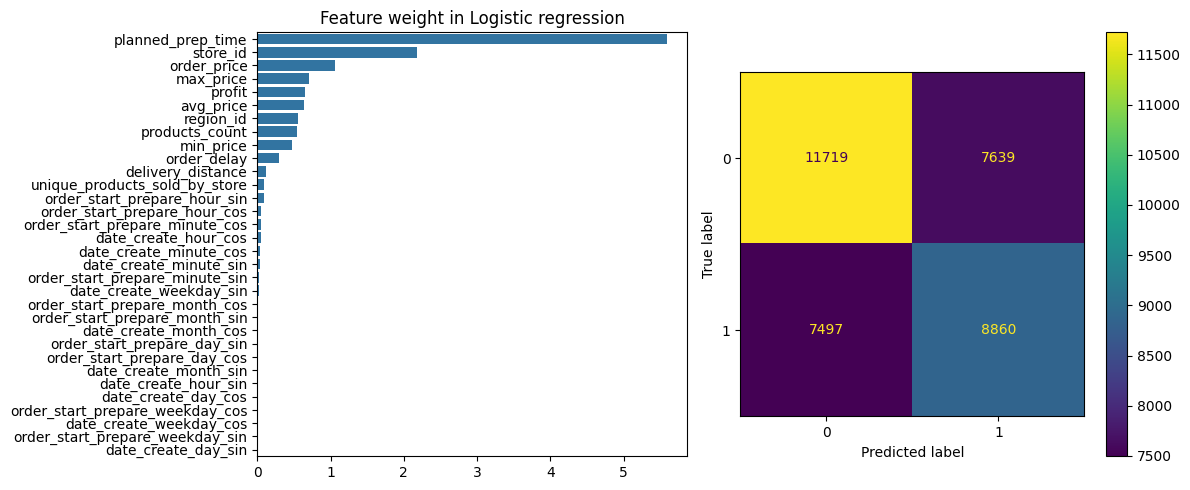

In [26]:
def train(trial: optuna.Trial):
    X_train, X_test, y_train, y_test = preprocess(trial,**trial.params)

    match trial.params['model']:
        case 'LogisticRegressor':
            model = LogisticRegression(random_state=42).fit(X_train, y_train)
            threshold = trial.user_attrs['best_threshold']
            logistic_regressor_scores(model, X_test, y_test, X_train, y_train, 7, cv_scoring=cv_scoring, best_threshold=threshold, plot=True)
        case 'CatBoostClassifier':
            cat_params = ['objective','colsample_bylevel', 'depth', 'boosting_type', 'bootstrap_type','bagging_temperature','subsample']
            model = CatBoostClassifier(**(fromkeys(trial.params, cat_params))).fit(X_train, y_train, 
                                        eval_set=[(X_test, y_test)], 
                                        verbose=0)
            threshold = trial.user_attrs['best_threshold']
            logistic_regressor_scores(model, X_test, y_test, X_train, y_train, 7, best_threshold=threshold, plot=True)
    
    return model

clf = train(trial)

In [ ]:
model = CatBoostClassifier().fit(X_train, y_train,         
                                early_stopping_rounds=100)
model.feature_importances_

In [ ]:
kernels = list(['linear', 'rbf', 'poly', 'sigmoid'])
c = list([1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 1e2, 1e3, 1e4,1e5])
gammas = list([0.1, 1, 10, 100])

clf = SVC()
clf.fit(X_train, y_train)
param_grid = dict(kernel=kernels, C=c, gamma=gammas)
grid = GridSearchCV(clf, param_grid, cv=10, n_jobs=-1, scoring='f1')
grid.fit(X_train, y_train)
grid.best_params_
n_components = range(len(X_smote.columns)-3, len(X_smote.columns)+1)
for component in n_components:
    pca = PCA(n_components=component, random_state=42)
    X_train_svc = pca.fit_transform(X_smote)
    X_test_svc = pca.transform(X_test)

    svc = SVC(kernel='rbf', degree=4, C=1, max_iter=1000)
    svc.fit(X_train_svc, y_smote)

    # print("Support vectors: ", svc.support_vectors_) # get support vectors
    # print("indices of support vectors: ", svc.support_) # get indices of support vectors
    print("\nnumber of support vectors for each class: ", svc.n_support_,'\n\n') # get number of support vectors for each class

    scores(svc, pd.DataFrame(X_test_svc), y_test, pd.DataFrame(X_train_svc), y_smote, threshold=None, plot=False)